In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Guadagno del PMT02

In [109]:
Stoppingpower=1 #MeV su g su cm
spessore=2.6 #cm
grammi=2 #g
DE=grammi*Stoppingpower *2.6 #MeV
conversione=1e4 #fotoni per Mev
fotoni=DE*conversione
quantum_efficiency=0.20 #e- per fotone
elettroni=quantum_efficiency*fotoni

In [110]:
DV=600e-3 #misurato all'oscilloscopio in V
t=20e-9 #durata del segnale in s
R=50 # resistenza all'oscilloscopio in Ohm
Q=DV*t/R #carica rilasciata

In [111]:
Qe=1.6 * 1e-19
gain=Q/(Qe*elettroni)
print(f"Guadagno del sistema {gain/1e5:.2f} 1e5 a 1900V, comparabile con il valore del manuale.")

Guadagno del sistema 1.44 1e5 a 1900V, comparabile con il valore del manuale.


In [112]:
DE=0.1# MeV
fotoni=DE*conversione
elettroni=quantum_efficiency*fotoni
Q=gain*Qe*elettroni
DV=Q*R/t
print(f"Voltaggio che mi aspetto in {DV*1e3:.2f} mV.")


Voltaggio che mi aspetto in 11.54 mV.


In [113]:
discrim = 28.5e-3
t=10e-9
Q = discrim * t / R
elettroni = Q / (gain * Qe)
fotoni = elettroni / quantum_efficiency
DE = fotoni / conversione
print(f"Deposito energia per minimo voltaggio visibile {DE * 1e3:.2f} KeV.")

# Che corrisponde a un angolo di...
E = 1.17 # MeV
E1 = E - DE
theta_rad = np.arccos(1 - (0.511/E)*(E/E1-1))
theta_deg = np.degrees(theta_rad)
print(f"Theta corrispondente {theta_rad:.2f} rad ({theta_deg:.2f} gradi).")

Deposito energia per minimo voltaggio visibile 123.50 KeV.
Theta corrispondente 0.32 rad (18.48 gradi).


## Grandezza del fascio 

In [2]:
senzabersaglio=np.sqrt(771)/6 #6 secondi
conbersaglio=np.sqrt(991)/6
diffbersaglio=991/6-771/6
errdiffbersaglio=np.sqrt(senzabersaglio**2+conbersaglio**2)
diffbersaglio/errdiffbersaglio
print(f"Differenza in rate a 115° {diffbersaglio:.1f} +- {errdiffbersaglio:.1f} Hz. Significatività in sigma: {diffbersaglio/errdiffbersaglio:.1f} ")

Differenza in rate a 115° 36.7 +- 7.0 Hz. Significatività in sigma: 5.2 


Posizione dell'asse del fascio (massima frequenza): 5.00 gradi
Angolo a sinistra della FWHM: -4.12 gradi
Angolo a destra della FWHM: 10.75 gradi
Larghezza completa a metà altezza (FWHM): 14.87 gradi


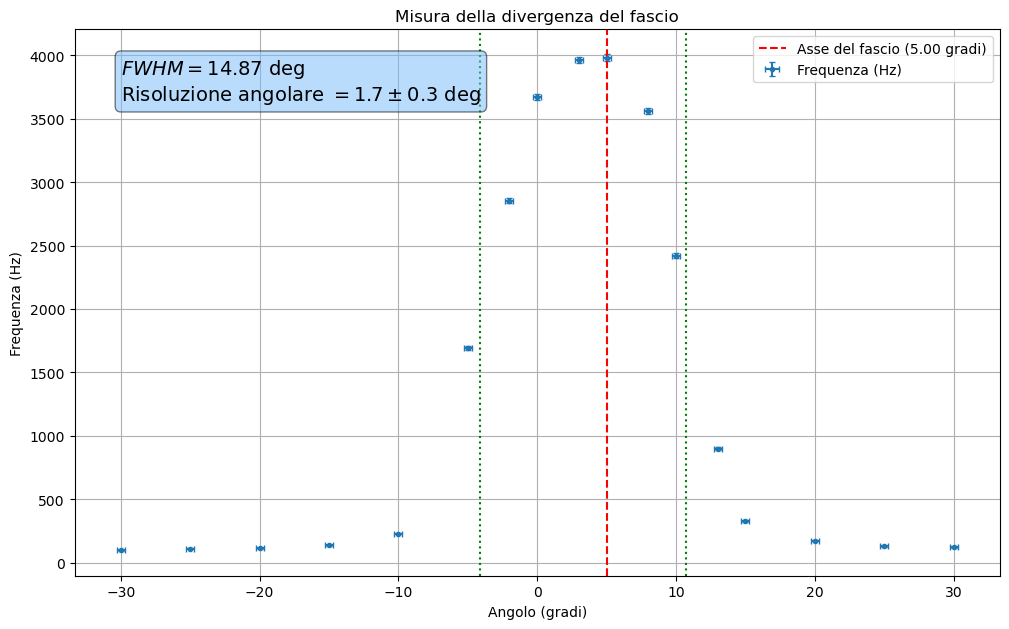

In [3]:
angles = np.array([60, 65, 70,
                   75, 80, 85,
                   88, 90, 93,
                   95, 98, 100, 103, 105,
                   110, 115, 120])-90 # Angoli (in gradi)
counts = np.array([584, 652, 693,
                   830, 1376, 10174,
                   17125, 22019, 23778,
                   23897, 21358, 14527, 5390, 1987,
                   1046, 771, 726])  # Conteggi (media delle ripetizioni quando presenti)

frequencies = counts / 6  # in 6 secondi, frequenza in Hz

# 1. Trova la frequenza massima e la sua posizione angolare
max_frequency = np.max(frequencies)
max_frequency_index = np.argmax(frequencies)
best_angle = angles[max_frequency_index]

# 2. Trova la metà della frequenza massima
half_max_frequency = max_frequency / 2

# 3. Stima gli angoli a metà altezza (FWHM) usando l'interpolazione lineare
def find_fwhm_angles(angles, frequencies, half_max_frequency):
    # Trova gli indici dove la frequenza supera la metà del massimo
    indices_above = np.where(frequencies > half_max_frequency)[0]

    # Trova gli indici a sinistra e a destra del picco
    indices_left = indices_above[indices_above < max_frequency_index]
    indices_right = indices_above[indices_above > max_frequency_index]

    # Gestisci il caso in cui non ci sono punti a sinistra del picco
    if len(indices_left) == 0:
        print("Avviso: Nessun punto sopra la metà del massimo a sinistra del picco.")
        return None, None  # Impossibile calcolare il lato sinistro della FWHM
    
    # Gestisci il caso in cui non ci sono punti a destra del picco
    if len(indices_right) == 0:
        print("Avviso: Nessun punto sopra la metà del massimo a destra del picco.")
        return None, None  # Impossibile calcolare il lato destro della FWHM

    # Trova l'indice più vicino a metà altezza a sinistra del picco
    left_index = indices_left[0]
    # Trova l'indice più vicino a metà altezza a destra del picco
    right_index = indices_right[-1]

    # Interpolazione lineare per stimare gli angoli
    def interpolate_angle(x1, y1, x2, y2, y_target):
        return x1 + (y_target - y1) * (x2 - x1) / (y2 - y1)
    
    left_angle = interpolate_angle(angles[left_index], frequencies[left_index],
                                   angles[left_index + 1], frequencies[left_index + 1],
                                   half_max_frequency)
    right_angle = interpolate_angle(angles[right_index - 1], frequencies[right_index - 1],
                                    angles[right_index], frequencies[right_index],
                                    half_max_frequency)

    return left_angle, right_angle

left_angle, right_angle = find_fwhm_angles(angles, frequencies, half_max_frequency)

# 4. Calcola la larghezza completa a metà altezza (FWHM)
if left_angle is not None and right_angle is not None:
    fwhm = right_angle - left_angle
    print(f"Posizione dell'asse del fascio (massima frequenza): {best_angle:.2f} gradi")
    print(f"Angolo a sinistra della FWHM: {left_angle:.2f} gradi")
    print(f"Angolo a destra della FWHM: {right_angle:.2f} gradi")
    print(f"Larghezza completa a metà altezza (FWHM): {fwhm:.2f} gradi")
else:
    print("Impossibile determinare FWHM. La metà della frequenza massima non è stata raggiunta.")

# Conversione della divergenza da radianti a gradi
divergenza_radianti = 1.2 / 40
err_diam = 0.2
err_dist = 0.2
error_rad = np.sqrt((err_diam / 40)**2 + (1.2 / (40**2) * err_dist)**2)
divergenza_gradi = divergenza_radianti * (180 / np.pi)
err_div = error_rad * (180 / np.pi)

# 5. Visualizzazione dei dati e della FWHM
fig, ax = plt.subplots(figsize=(10, 6))
errors = np.sqrt(counts) / 6  # errori sui conteggi (radice quadrata del conteggio)
angle_errors=err_div*np.ones(len(errors))
ax.errorbar(angles, frequencies, yerr=errors, xerr=angle_errors, fmt='.', label='Frequenza (Hz)', capsize=2.5)

# Aggiungi la linea di tendenza che passa per i dati
ax.axvline(x=best_angle, color='red', linestyle='--', label=f'Asse del fascio ({best_angle:.2f} gradi)')

if left_angle is not None and right_angle is not None:
    ax.axvline(x=left_angle, color='green', linestyle=':')
    ax.axvline(x=right_angle, color='green', linestyle=':')
    #ax.axhline(y=half_max_frequency, color='purple', linestyle='-.', label=f'Metà Max Freq ({half_max_frequency:.2f} Hz)')

textstr = '\n'.join((
    r'$FWHM=%.2f$ deg' % (fwhm, ),
    r'Risoluzione angolare $=%.1f \pm %.1f$ deg' % (divergenza_gradi, err_div)
    ))

# Define the properties of the text box
properties = dict(boxstyle='round', facecolor='xkcd:sky blue', alpha=0.5)

# Add the text box to the plot
# Position the box in the top left corner (0.05, 0.95) in axes coordinates
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=properties)

# Display the plot
plt.tight_layout()
plt.xlabel('Angolo (gradi)')
plt.ylabel('Frequenza (Hz)')
plt.title('Misura della divergenza del fascio')
plt.grid(True)
plt.legend()
plt.show()

3393.665744300699


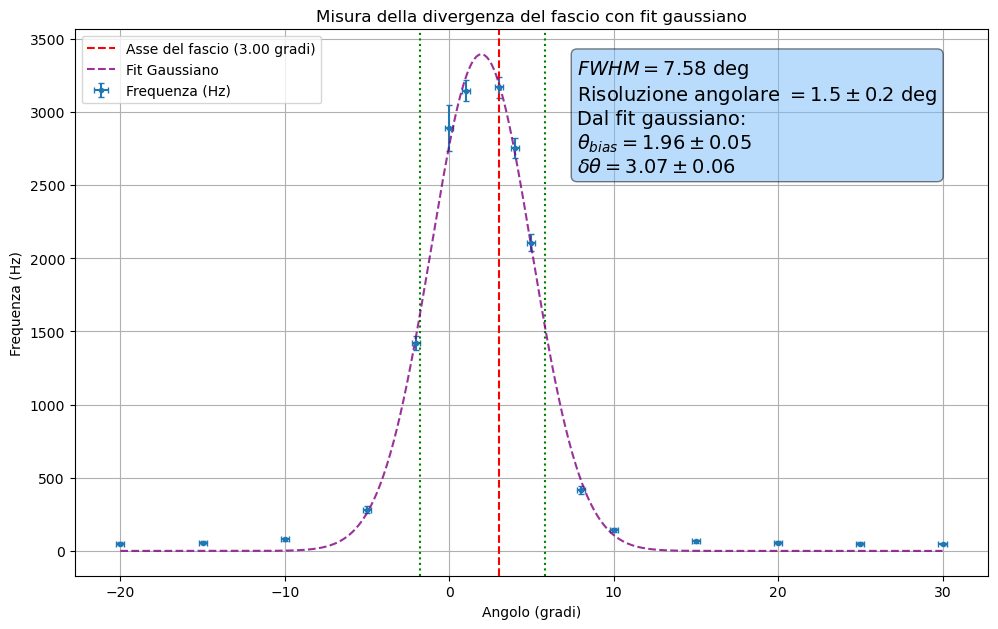

Angolo medio: 1.96 ± 0.05 gradi
Deviazione Standard: 3.07 ± 0.06 gradi
FWHM: 7.58 gradi
Risoluzione angolare: 1.5 ± 0.2 gradi
Ampiezza: 3393.67 ± 0.05 Hz
Chi-quadro: 257.40
Gradi di libertà: 13
Chi-quadro ridotto: 19.80


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Dati forniti
angles = np.array([70, 75, 80, 85, 88, 
                   90, 91, 93, 94,
                    95, 98, 100, 105, 
                    110, 115, 120])-90  # Angoli (in gradi)
counts = np.array([2926, 3381, 4758, 16914, 85365, 866852, 188621, 190072, 
                   165300, 126359, 24929, 8654, 4008, 3279, 3019, 2837])

frequencies = counts / 60  # in 60 secondi, frequenza in Hz
frequencies[5] = frequencies[5] / 5

# Trova la frequenza massima e la sua posizione angolare
max_frequency = np.max(frequencies)
max_frequency_index = np.argmax(frequencies)
best_angle = angles[max_frequency_index]

# Trova la metà della frequenza massima
half_max_frequency = max_frequency / 2

# Stima gli angoli a metà altezza (FWHM) usando l'interpolazione lineare
def find_fwhm_angles(angles, frequencies, half_max_frequency):
    # Trova gli indici dove la frequenza supera la metà del massimo
    indices_above = np.where(frequencies > half_max_frequency)[0]

    # Trova gli indici a sinistra e a destra del picco
    indices_left = indices_above[indices_above < max_frequency_index]
    indices_right = indices_above[indices_above > max_frequency_index]

    # Gestisci il caso in cui non ci sono punti a sinistra del picco
    if len(indices_left) == 0:
        print("Avviso: Nessun punto sopra la metà del massimo a sinistra del picco.")
        return None, None  # Impossibile calcolare il lato sinistro della FWHM
    
    # Gestisci il caso in cui non ci sono punti a destra del picco
    if len(indices_right) == 0:
        print("Avviso: Nessun punto sopra la metà del massimo a destra del picco.")
        return None, None  # Impossibile calcolare il lato destro della FWHM

    # Trova l'indice più vicino a metà altezza a sinistra del picco
    left_index = indices_left[0]
    # Trova l'indice più vicino a metà altezza a destra del picco
    right_index = indices_right[-1]

    # Interpolazione lineare per stimare gli angoli
    def interpolate_angle(x1, y1, x2, y2, y_target):
        return x1 + (y_target - y1) * (x2 - x1) / (y2 - y1)
    
    left_angle = interpolate_angle(angles[left_index], frequencies[left_index],
                                     angles[left_index -1], frequencies[left_index -1],
                                     half_max_frequency)
    right_angle = interpolate_angle(angles[right_index - 1], frequencies[right_index - 1],
                                     angles[right_index], frequencies[right_index],
                                     half_max_frequency)

    return left_angle, right_angle

left_angle, right_angle = find_fwhm_angles(angles, frequencies, half_max_frequency)

# Calcola la larghezza completa a metà altezza (FWHM)
if left_angle is not None and right_angle is not None:
    fwhm = right_angle - left_angle

# Conversione della risoluzione da radianti a gradi
risoluzione_radianti = 1.2 / 47
err_diam = 0.2
err_dist = 0.2
error_rad = np.sqrt((err_diam / 47) ** 2 + (1.2 / (47 ** 2) * err_dist) ** 2)
risoluzione_gradi = risoluzione_radianti * (180 / np.pi)
err_ris = error_rad * (180 / np.pi)

# Fit gaussiano
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

popt, pcov = curve_fit(gaussian, angles, frequencies, p0=[np.max(frequencies), angles[np.argmax(frequencies)], 10])
amp, mean, stddev = popt
print(amp)
mean_error = np.sqrt(pcov[1, 1])
stddev_error = np.sqrt(pcov[2, 2])

# Visualizzazione dei dati e della FWHM
fig, ax = plt.subplots(figsize=(10, 6))
errors = np.sqrt(counts) / 6  # errori sui conteggi (radice quadrata del conteggio)
angle_errors = err_ris * np.ones(len(errors))
ax.errorbar(angles, frequencies, yerr=errors, xerr=angle_errors, fmt='.', label='Frequenza (Hz)', capsize=2.5)
ax.axvline(x=best_angle, color='red', linestyle='--', label=f'Asse del fascio ({best_angle:.2f} gradi)')

if left_angle is not None and right_angle is not None:
    ax.axvline(x=left_angle, color='green', linestyle=':')
    ax.axvline(x=right_angle, color='green', linestyle=':')
    #ax.axhline(y=half_max_frequency, color='purple', linestyle='-.', label=f'Metà Max Freq ({half_max_frequency:.2f} Hz)')

# Fit gaussiano
x_fit = np.linspace(min(angles), max(angles), 1000)
y_fit = gaussian(x_fit, *popt)
ax.plot(x_fit, y_fit, linestyle='--', color='purple', alpha=0.8, label='Fit Gaussiano')

# Informazioni del fit e della FWHM
textstr = '\n'.join((
    r'$FWHM=%.2f$ deg' % (fwhm, ),
    r'Risoluzione angolare $=%.1f \pm %.1f$ deg' % (risoluzione_gradi, err_ris),
    r"Dal fit gaussiano:", 
    r'$\theta_{bias}=%.2f \pm %.2f$' % (mean, mean_error),
    r'$\delta\theta=%.2f \pm %.2f$' % (stddev, stddev_error)
    ))

# Definizione delle proprietà della casella di testo
properties = dict(boxstyle='round', facecolor='xkcd:sky blue', alpha=0.5)

# Aggiungi la casella di testo al grafico
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=properties)

# Display the plot
plt.tight_layout()
plt.xlabel('Angolo (gradi)')
plt.ylabel('Frequenza (Hz)')
plt.title('Misura della divergenza del fascio con fit gaussiano')
plt.grid(True)
plt.legend()
plt.show()

# Stampa dei risultati
print(f"Angolo medio: {mean:.2f} ± {mean_error:.2f} gradi")
print(f"Deviazione Standard: {stddev:.2f} ± {stddev_error:.2f} gradi")
print(f"FWHM: {fwhm:.2f} gradi")
print(f"Risoluzione angolare: {risoluzione_gradi:.1f} ± {err_ris:.1f} gradi")
print(f"Ampiezza: {popt[0]:.2f} ± {np.sqrt(pcov[1, 1]):.2f} Hz")

# Calcolo del chi-quadro
residuals = frequencies - gaussian(angles, *popt)
chi_squared = np.sum((residuals / errors) ** 2)

# Gradi di libertà
degrees_of_freedom = len(angles) - len(popt)

# Stampa dei risultati
print(f"Chi-quadro: {chi_squared:.2f}")
print(f"Gradi di libertà: {degrees_of_freedom}")
print(f"Chi-quadro ridotto: {chi_squared / degrees_of_freedom:.2f}")


## Coincidenze accidentali e segnale

In [117]:
"""#Controllo preliminare a 20 gradi di deflessione dall'asse:

counts_coincidenze=np.array([32, 27, 34, 21, 27]) #conteggi
counts_PMT1=np.array([812, 828, 898, 767, 796])
counts_PMT2=np.array([3927, 13788, 14046, 13799, 13816])

coincidenze=counts_coincidenze/6 #rate in Hz
PMT1=counts_PMT1/6
PMT2=counts_PMT2/6

coinc=np.mean(coincidenze) #valori di media e deviazione standard
sigma_coinc=np.std(coincidenze)

PMT1_mean=np.mean(PMT1) 
sigma_PMT1=np.std(PMT1)
PMT2_mean=np.mean(PMT2)
sigma_PMT2=np.std(PMT2)

#valutare coincidenze accidentali
rate_acc=PMT1_mean*PMT2_mean*(136e-9+90e-9-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2_mean*(136e-9+90e-9-2*2e-9))**2+(PMT1_mean*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc:.1f} +- {sigma_coinc:.1f} Hz")
print(f"Rate accidentale {rate_acc:.2f} +- {sigma_rate_acc:.2f} Hz ")
diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 70° {diff:.1f} +- {err_diff:.1f}. Significatività in sigma {diff/err_diff:.1f} ")"""

'#Controllo preliminare a 20 gradi di deflessione dall\'asse:\n\ncounts_coincidenze=np.array([32, 27, 34, 21, 27]) #conteggi\ncounts_PMT1=np.array([812, 828, 898, 767, 796])\ncounts_PMT2=np.array([3927, 13788, 14046, 13799, 13816])\n\ncoincidenze=counts_coincidenze/6 #rate in Hz\nPMT1=counts_PMT1/6\nPMT2=counts_PMT2/6\n\ncoinc=np.mean(coincidenze) #valori di media e deviazione standard\nsigma_coinc=np.std(coincidenze)\n\nPMT1_mean=np.mean(PMT1) \nsigma_PMT1=np.std(PMT1)\nPMT2_mean=np.mean(PMT2)\nsigma_PMT2=np.std(PMT2)\n\n#valutare coincidenze accidentali\nrate_acc=PMT1_mean*PMT2_mean*(136e-9+90e-9-2*2e-9)\nsigma_rate_acc=np.sqrt((sigma_PMT1*PMT2_mean*(136e-9+90e-9-2*2e-9))**2+(PMT1_mean*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)\n\nprint(f"Rate coincidenze {coinc:.1f} +- {sigma_coinc:.1f} Hz")\nprint(f"Rate accidentale {rate_acc:.2f} +- {sigma_rate_acc:.2f} Hz ")\ndiff=coinc-rate_acc\nerr_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)\nprint(f"Differenza in rate a 70° {diff:.1f} +- {err_di

In [12]:
#COINCIDENZE A 70 GRADI
PMT1=31208/(10*60)
sigma_PMT1=np.sqrt(3208)/(10*60)
PMT2=1446095/(10*60)
sigma_PMT2=np.sqrt(1446095)/(10*60)
print(f"Rate PMT1 {PMT1:.2f} +- {sigma_PMT1:.2f} Hz")
print(f"Rate PMT2 {PMT2:.0f} +- {sigma_PMT2:.0f} Hz")
coinc=679/(10*60)
sigma_coinc=np.sqrt(679)/(10*60)
dPMT1=90e-9
dPMT2=130e-9
rate_acc=PMT1*PMT2*(dPMT1+dPMT2-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2*(136e-9+90e-9-2*2e-9))**2+(PMT1*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc:.2f} +- {sigma_coinc:.2f} Hz")
print(f"Rate accidentale {rate_acc*1e3:.1f} +- {sigma_rate_acc*1e3:.1f} mHz ")
print(f"Percentuale {rate_acc/coinc*100:.2f}")
diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 70° {diff:.2f} +- {err_diff:.2f}. Significatività in sigma {diff/err_diff:.1f} ")

Rate PMT1 52.01 +- 0.09 Hz
Rate PMT2 2410 +- 2 Hz
Rate coincidenze 1.13 +- 0.04 Hz
Rate accidentale 27.1 +- 0.1 mHz 
Percentuale 2.39
Differenza in rate a 70° 1.10 +- 0.04. Significatività in sigma 25.4 


In [13]:
#COINCIDENZE A 70 GRADI
PMT1=3208/(10*60)
sigma_PMT1=np.sqrt(3208)/(10*60)
PMT2=1446095/(10*60)
sigma_PMT2=np.sqrt(1446095)/(10*60)
print(f"Rate PMT1 {PMT1:.2f} +- {sigma_PMT1:.2f} Hz")
print(f"Rate PMT2 {PMT2:.0f} +- {sigma_PMT2:.0f} Hz")
coinc=679/(10*60)
sigma_coinc=np.sqrt(679)/(10*60)
dPMT1=90e-9
dPMT2=130e-9
rate_acc=PMT1*PMT2*(dPMT1+dPMT2-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2*(136e-9+90e-9-2*2e-9))**2+(PMT1*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc:.2f} +- {sigma_coinc:.2f} Hz")
print(f"Rate accidentale {rate_acc*1e3:.1f} +- {sigma_rate_acc*1e3:.1f} mHz ")
print(f"Percentuale {rate_acc/coinc*100:.2f}")
diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 70° {diff:.2f} +- {err_diff:.2f}. Significatività in sigma {diff/err_diff:.1f} ")

Rate PMT1 5.35 +- 0.09 Hz
Rate PMT2 2410 +- 2 Hz
Rate coincidenze 1.13 +- 0.04 Hz
Rate accidentale 2.8 +- 0.1 mHz 
Percentuale 0.25
Differenza in rate a 70° 1.13 +- 0.04. Significatività in sigma 26.0 


In [14]:
#COINCIDENZE A 75 GRADI
#PMT1=118800/(9999.999)
PMT1=593414/(9999.999)
sigma_PMT1=np.sqrt(593414)/(999.999)
PMT2=22732986/(999.999)
sigma_PMT2=np.sqrt(22732986)/(999.999)
print(f"Rate PMT1 {PMT1:.2f} +- {sigma_PMT1:.2f} Hz")
print(f"Rate PMT2 {PMT2:.0f} +- {sigma_PMT2:.0f} Hz")
coinc=2409/(999.999)
sigma_coinc=np.sqrt(2409)/(999.999)
dPMT1=90e-9
dPMT2=130e-9
rate_acc=PMT1*PMT2*(dPMT1+dPMT2-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2*(136e-9+90e-9-2*2e-9))**2+(PMT1*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc:.2f} +- {sigma_coinc:.2f} Hz")
print(f"Rate accidentale {rate_acc*1e3:.1f} +- {sigma_rate_acc*1e3:.1f} mHz ")
print(f"Percentuale {rate_acc/coinc*100:.2f}")
diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 75° {diff:.2f} +- {err_diff:.2f}. Significatività in sigma {diff/err_diff:.1f} ")

Rate PMT1 59.34 +- 0.77 Hz
Rate PMT2 22733 +- 5 Hz
Rate coincidenze 2.41 +- 0.05 Hz
Rate accidentale 291.4 +- 3.9 mHz 
Percentuale 12.10
Differenza in rate a 75° 2.12 +- 0.05. Significatività in sigma 43.0 


In [15]:
#COINCIDENZE A 80 GRADI
PMT1=46683/(10*60)
sigma_PMT1=np.sqrt(46683)/(10*60)
PMT2=1443530/(10*60)
sigma_PMT2=np.sqrt(1446095)/(10*60)
print(f"Rate PMT1 {PMT1:.2f} +- {sigma_PMT1:.2f} Hz")
print(f"Rate PMT2 {PMT2:.0f} +- {sigma_PMT2:.0f} Hz")
coinc=133/(10*60)
sigma_coinc=np.sqrt(133)/(10*60)
dPMT1=90e-9
dPMT2=130e-9
rate_acc=PMT1*PMT2*(dPMT1+dPMT2-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2*(136e-9+90e-9-2*2e-9))**2+(PMT1*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc*1e3:.2f} +- {sigma_coinc*1e3:.2f} mHz")
print(f"Rate accidentale {rate_acc*1e3:.1f} +- {sigma_rate_acc*1e3:.1f} mHz ")
print(f"Percentuale {rate_acc/coinc*100:.2f}")

diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 80° {diff:.1f} +- {err_diff:.1f}. Significatività in sigma {diff/err_diff:.1f} ")

Rate PMT1 77.81 +- 0.36 Hz
Rate PMT2 2406 +- 2 Hz
Rate coincidenze 221.67 +- 19.22 mHz
Rate accidentale 40.4 +- 0.2 mHz 
Percentuale 18.24
Differenza in rate a 80° 0.2 +- 0.0. Significatività in sigma 9.4 


In [16]:
#COINCIDENZE A 115 GRADI
PMT1=3460/(60)
sigma_PMT1=np.sqrt(3460)/(60)
PMT2=139200/(60)
sigma_PMT2=np.sqrt(139200)/(60)
print(f"Rate PMT1 {PMT1:.2f} +- {sigma_PMT1:.2f} Hz")
print(f"Rate PMT2 {PMT2:.0f} +- {sigma_PMT2:.0f} Hz")
coinc=77/(60)
sigma_coinc=np.sqrt(77)/(60)
dPMT1=90e-9
dPMT2=130e-9
rate_acc=PMT1*PMT2*(dPMT1+dPMT2-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2*(136e-9+90e-9-2*2e-9))**2+(PMT1*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc:.2f} +- {sigma_coinc:.2f} Hz")
print(f"Rate accidentale {rate_acc*1e3:.2f} +- {sigma_rate_acc*1e3:.2f} mHz ")
print(f"Percentuale {rate_acc/coinc*100:.2f}")

diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 115° {diff:.1f} +- {err_diff:.1f}. Significatività in sigma {diff/err_diff:.1f} ")

Rate PMT1 57.67 +- 0.98 Hz
Rate PMT2 2320 +- 6 Hz
Rate coincidenze 1.28 +- 0.15 Hz
Rate accidentale 28.90 +- 0.51 mHz 
Percentuale 2.25
Differenza in rate a 115° 1.3 +- 0.1. Significatività in sigma 8.6 


In [17]:
#COINCIDENZE A 120 GRADI
PMT1=3371/(60)
sigma_PMT1=np.sqrt(3371)/(60)
PMT2=142568/(60)
sigma_PMT2=np.sqrt(142568)/(60)
print(f"Rate PMT1 {PMT1:.2f} +- {sigma_PMT1:.2f} Hz")
print(f"Rate PMT2 {PMT2:.0f} +- {sigma_PMT2:.0f} Hz")
coinc=101/(60)
sigma_coinc=np.sqrt(101)/(60)
dPMT1=90e-9
dPMT2=130e-9
rate_acc=PMT1*PMT2*(dPMT1+dPMT2-2*2e-9)
sigma_rate_acc=np.sqrt((sigma_PMT1*PMT2*(136e-9+90e-9-2*2e-9))**2+(PMT1*sigma_PMT2*(136e-9+90e-9-2*2e-9))**2)

print(f"Rate coincidenze {coinc:.2f} +- {sigma_coinc:.2f} Hz")
print(f"Rate accidentale {rate_acc*1e3:.2f} +- {sigma_rate_acc*1e3:.2f} mHz ")
print(f"Percentuale {rate_acc/coinc*100:.2f}")

diff=coinc-rate_acc
err_diff=np.sqrt(sigma_rate_acc**2+sigma_coinc**2)
print(f"Differenza in rate a 120° {diff:.1f} +- {err_diff:.1f}. Significatività in sigma {diff/err_diff:.1f} ")

Rate PMT1 56.18 +- 0.97 Hz
Rate PMT2 2376 +- 6 Hz
Rate coincidenze 1.68 +- 0.17 Hz
Rate accidentale 28.84 +- 0.52 mHz 
Percentuale 1.71
Differenza in rate a 120° 1.7 +- 0.2. Significatività in sigma 9.9 


In [18]:
# Angoli riscalati rispetto al bias
angoli = np.array([75, 70, 80, 115, 120])-(90+mean)
print(f"Angoli {[75, 70, 80, 115, 120]} rispetto al bias: {angoli}")

NameError: name 'mean' is not defined

In [9]:
counts_PMT1_solo=693
counts_PMT1_coppia=937
time=6

rate_solo=counts_PMT1_solo/time
err_rate_solo=np.sqrt(counts_PMT1_solo)/time
rate_coppia=counts_PMT1_coppia/time
err_rate_coppia=np.sqrt(counts_PMT1_coppia)/time

diffbersaglio=rate_coppia-rate_solo
errdiffbersaglio=np.sqrt(err_rate_solo**2+err_rate_coppia**2)

print(f"Rate PMT1 senza bersaglio {rate_solo:.0f} +- {err_rate_solo:.0f} Hz")
print(f"Rate PMT1 con bersaglio {rate_coppia:.0f} +- {err_rate_coppia:.0f} Hz")
print(f"Differenza in rate a 70° {diffbersaglio:.0f} +- {errdiffbersaglio:.0f} Hz. Significatività in sigma: {diffbersaglio/errdiffbersaglio:.1f} ")

Rate PMT1 senza bersaglio 116 +- 4 Hz
Rate PMT1 con bersaglio 156 +- 5 Hz
Differenza in rate a 70° 41 +- 7 Hz. Significatività in sigma: 6.0 


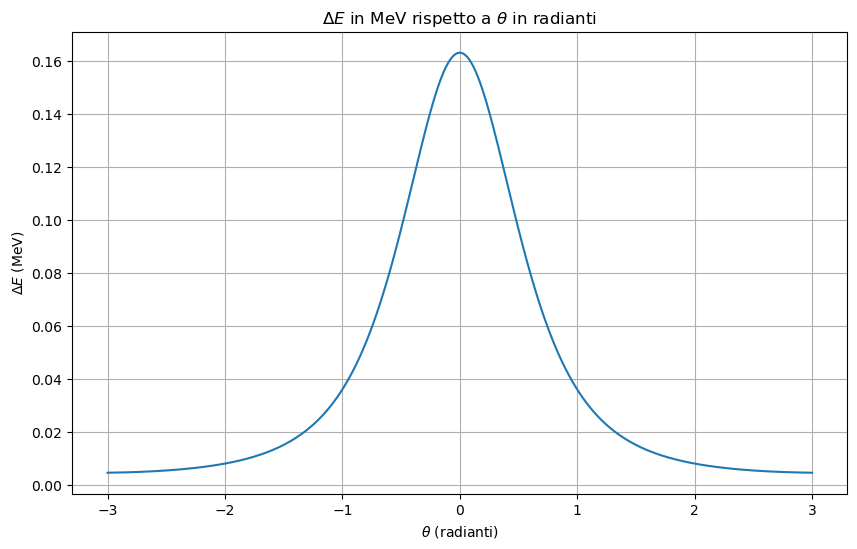

In [6]:
# Definisci le costanti
E2 = 1.333  # MeV
E1 = 1.17   # MeV
me = 0.511  # MeV

# Crea un array di theta da 0 a 3 radianti
theta = np.linspace(-3, 3, 1000)

# Calcola DE_fatt1 e DE_fatt2
DE_fatt1 = E2 / (1 + E2 / me * (1 - np.cos(theta)))
DE_fatt2 = E1 / (1 + E1 / me * (1 - np.cos(theta)))

# Calcola DE
DE = DE_fatt1 - DE_fatt2

# Crea il grafico
plt.figure(figsize=(10, 6))
plt.plot(theta, DE)
plt.xlabel(r'$\theta$ (radianti)')
plt.ylabel(r'$\Delta E$ (MeV)')
plt.title(r'$\Delta E$ in MeV rispetto a $\theta$ in radianti')
plt.grid(True)
plt.show()

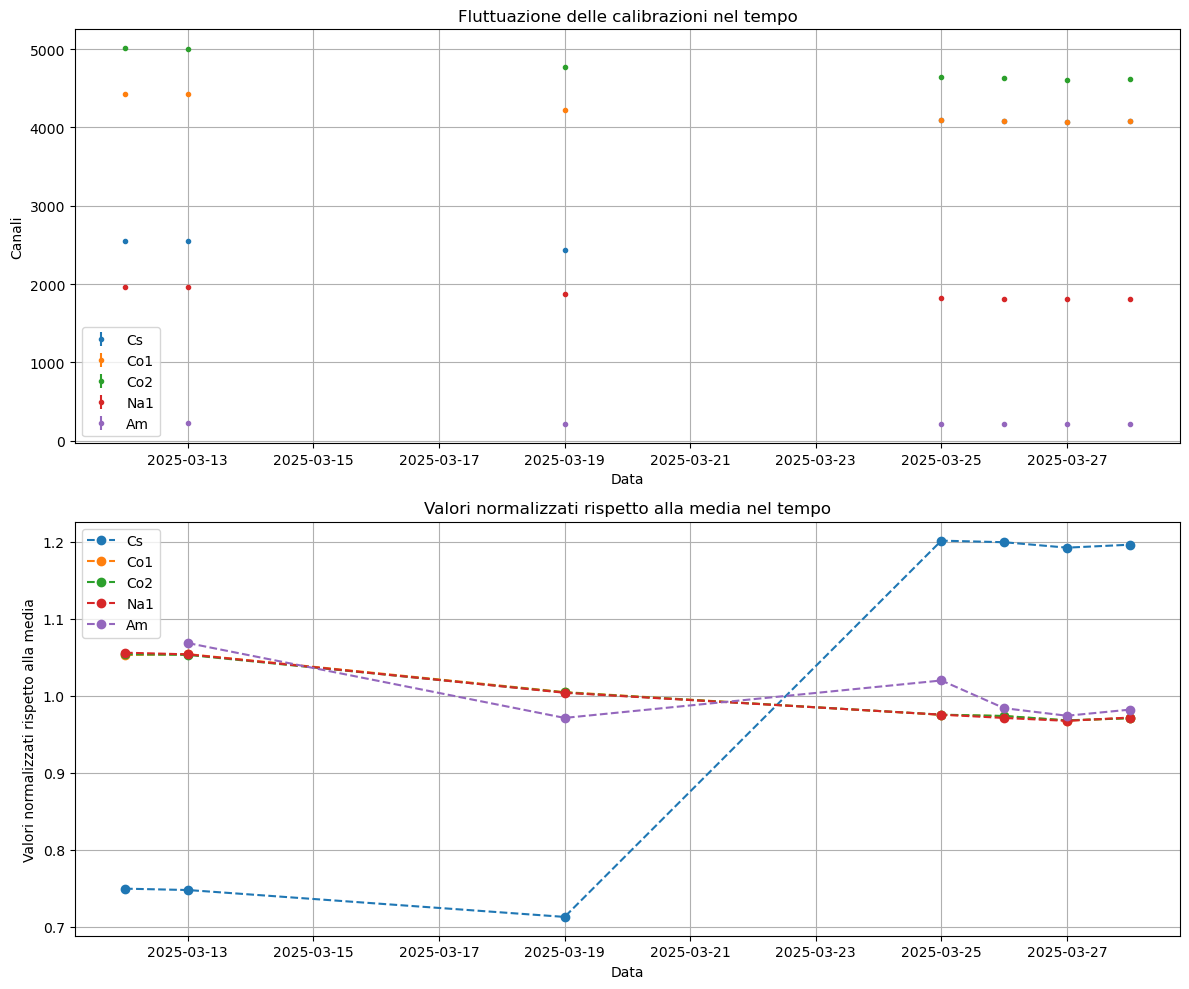

Maximum successive variation in percentage for each array:
Cs: 68.55%
Co1: 4.68%
Co2: 4.63%
Na1: 4.74%
Am: 9.10%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Data
dates = ["12.03", "13.03","19.03", "25.03", "26.03", "27.03", "28.03"]
dates = [datetime.datetime.strptime(date + ".2025", "%d.%m.%Y") for date in dates]

Cs = np.array([2554.0, 2548.0, 2429.0,
               4094, 4087, 4063, 4076])
dCs = np.array([0.3, 0.4, 0.1,
                1, 1, 1, 1])

Co1 = np.array([4420, 4425,4218,
                4094, 4087, 4063, 4076])
dCo1 = np.array([1, 1, 1,
                 1, 1, 1, 1])

Co2 = np.array([5010, 5006, 4774,
                4637, 4629, 4602, 4615])
dCo2 = np.array([1, 1,1,
                 1, 1, 1, 1])

Na1 = np.array([1968, 1964, 1871,
                1818, 1810, 1803, 1811])
dNa1 = np.array([1, 1, 1,
                 1, 1, 1, 1])

Am = np.array([228.6, 207.8,
               218.2, 210.5, 208.4, 210.1])
dAm = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Plot data
plt.figure(figsize=(12, 10))

# Plot channels
plt.subplot(2, 1, 1)
plt.errorbar(dates, Cs, yerr=dCs, fmt='.', label='Cs')
plt.errorbar(dates, Co1, yerr=dCo1, fmt='.', label='Co1')
plt.errorbar(dates, Co2, yerr=dCo2, fmt='.', label='Co2')
plt.errorbar(dates, Na1, yerr=dNa1, fmt='.', label='Na1')
plt.errorbar(dates[1:], Am, yerr=dAm, fmt='.', label='Am')

plt.xlabel("Data")
plt.ylabel("Canali")
plt.legend()
plt.grid()
plt.title("Fluttuazione delle calibrazioni nel tempo")

# Normalize values relative to mean
Cs_norm = Cs / np.mean(Cs)
Co1_norm = Co1 / np.mean(Co1)
Co2_norm = Co2 / np.mean(Co2)
Na1_norm = Na1 / np.mean(Na1)
Am_norm = Am / np.mean(Am)

# Plot normalized values
plt.subplot(2, 1, 2)
plt.plot(dates, Cs_norm, 'o--', label='Cs')
plt.plot(dates, Co1_norm, 'o--', label='Co1')
plt.plot(dates, Co2_norm, 'o--', label='Co2')
plt.plot(dates, Na1_norm, 'o--', label='Na1')
plt.plot(dates[1:], Am_norm, 'o--', label='Am')

plt.xlabel("Data")
plt.ylabel("Valori normalizzati rispetto alla media")
plt.legend(loc="best")
plt.title("Valori normalizzati rispetto alla media nel tempo")

# Show plot
plt.tight_layout()
plt.grid()
plt.show()

# Calculate maximum variation in percentage between successive values
def max_successive_variation(arr):
    return np.max(np.abs(np.diff(arr) / arr[:-1]) * 100)

max_variation_successive = {
    "Cs": max_successive_variation(Cs),
    "Co1": max_successive_variation(Co1),
    "Co2": max_successive_variation(Co2),
    "Na1": max_successive_variation(Na1),
    "Am": max_successive_variation(Am)
}

print("Maximum successive variation in percentage for each array:")
for key, value in max_variation_successive.items():
    print(f"{key}: {value:.2f}%")